In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# ========= 1. LOAD RAW BOSTON DATA =========
# ⬇️ change this to your actual file name
boston_raw_path = "/Users/prateek/Documents/FDS Project/dataset/boston.csv"

df = pd.read_csv(boston_raw_path)
print("Raw shape:", df.shape)
print(df.columns)

# ========= 2. BASIC CLEANING =========

# Keep only rows with valid coordinates
df = df.dropna(subset=["Lat", "Long"])
df = df.drop_duplicates()

# Rename columns to match Chicago schema
df = df.rename(columns={
    "OFFENSE_DESCRIPTION": "Crime_Type",
    "Lat": "Latitude",
    "Long": "Longitude",
    "HOUR": "Hour",
    "DAY_OF_WEEK": "DayOfWeek",
})

# Parse datetime (if you need it later)
df["OCCURRED_ON_DATE"] = pd.to_datetime(df["OCCURRED_ON_DATE"], errors="coerce")

# ========= 3. TIME-BASED FEATURES =========

# If Hour already exists as int, just ensure type
df["Hour"] = pd.to_numeric(df["Hour"], errors="coerce").fillna(0).astype(int)

# Map DayOfWeek strings to 0–6
day_map = {
    "Monday": 0,
    "Tuesday": 1,
    "Wednesday": 2,
    "Thursday": 3,
    "Friday": 4,
    "Saturday": 5,
    "Sunday": 6,
}
df["DayOfWeek_num"] = df["DayOfWeek"].map(day_map)
# If any NaNs (weird values), fill with 0 (Monday)
df["DayOfWeek_num"] = df["DayOfWeek_num"].fillna(0).astype(int)

# Weekend flag
df["IsWeekend"] = df["DayOfWeek"].isin(["Saturday", "Sunday"]).astype(int)

# Light condition: 1 = Day, 0 = Night
df["Light_Condition"] = df["Hour"].apply(lambda h: 1 if 6 <= h <= 18 else 0)

# ========= 4. WEATHER (SYNTHETIC) =========

np.random.seed(42)
df["Temperature"] = np.random.normal(loc=25, scale=5, size=len(df)).round(1)
df["Rain"] = np.random.choice([0, 1], size=len(df), p=[0.8, 0.2])

# ========= 5. SPATIAL ZONES (KMEANS) =========

# Use only reasonable rows
coords = df[["Latitude", "Longitude"]].dropna()

# Choose number of zones (you can change 5 to 8/10)
n_zones = 5
kmeans = KMeans(n_clusters=n_zones, random_state=42, n_init=10)
df["Zone"] = kmeans.fit_predict(coords)

# NOTE: because dropna might reduce rows, we align by index:
df.loc[coords.index, "Zone"] = kmeans.labels_
df["Zone"] = df["Zone"].astype(int)

# ========= 6. LOCATION_TYPE_LABEL =========
# We don't have a direct location-type column like Chicago.
# We’ll encode DISTRICT (or STREET) as a proxy for location type.

if "DISTRICT" in df.columns:
    df["Location_Type_Label"] = df["DISTRICT"].astype("category").cat.codes
else:
    # fallback: use STREET
    df["Location_Type_Label"] = df["STREET"].astype("category").cat.codes

# ========= 7. ARREST / DOMESTIC FLAGS =========
# Boston dataset doesn’t have those, so we set 0 as default
df["Arrest"] = 0
df["Domestic"] = 0

# ========= 8. FINAL COLUMN ORDER =========

final_cols = [
    "Crime_Type",
    "Latitude",
    "Longitude",
    "Zone",
    "Hour",
    "DayOfWeek_num",   # numeric 0–6
    "IsWeekend",
    "Light_Condition",
    "Temperature",
    "Rain",
    "Location_Type_Label",
    "Arrest",
    "Domestic",
]

boston_clean = df[final_cols].rename(columns={"DayOfWeek_num": "DayOfWeek"})

print("Clean shape:", boston_clean.shape)
print(boston_clean.head())

# OPTIONAL: also create numeric label for Crime_Type if you want
boston_clean["Crime_Type_Label"], crime_type_index = pd.factorize(boston_clean["Crime_Type"])
print("Number of unique crime types:", len(crime_type_index))

# ========= 9. SAVE CLEAN FILE =========

out_path = "../dataset/boston_crime_features.csv"
boston_clean.to_csv(out_path, index=False)
print(f"✅ Saved cleaned Boston data to {out_path}")


/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_5547/1646491957.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(boston_raw_path)


Raw shape: (220135, 17)
Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location'],
      dtype='object')


/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/prateek/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = cl

Clean shape: (205980, 13)
             Crime_Type   Latitude  Longitude  Zone  Hour  DayOfWeek  \
0    INVESTIGATE PERSON  42.271661 -71.099535     1    22          0   
1           SICK ASSIST  42.301387 -71.065843     3    11          0   
2        VERBAL DISPUTE  42.312596 -71.092876     4    20          0   
3    INVESTIGATE PERSON  42.365699 -71.052892     0     0          0   
4  INVESTIGATE PROPERTY  42.292788 -71.088520     3    17          0   

   IsWeekend  Light_Condition  Temperature  Rain  Location_Type_Label  Arrest  \
0          0                0         27.5     0                    4       0   
1          0                1         24.3     1                    5       0   
2          0                0         28.2     1                    3       0   
3          0                0         32.6     0                    0       0   
4          0                1         23.8     0                    4       0   

   Domestic  
0         0  
1         0  
2         0 

Boston Cleaned Shape: (205980, 14)
Columns: ['Crime_Type', 'Latitude', 'Longitude', 'Zone', 'Hour', 'DayOfWeek', 'IsWeekend', 'Light_Condition', 'Temperature', 'Rain', 'Location_Type_Label', 'Arrest', 'Domestic', 'Crime_Type_Label']

=== Missing Values ===
Crime_Type             0
Latitude               0
Longitude              0
Zone                   0
Hour                   0
DayOfWeek              0
IsWeekend              0
Light_Condition        0
Temperature            0
Rain                   0
Location_Type_Label    0
Arrest                 0
Domestic               0
Crime_Type_Label       0
dtype: int64

=== Summary Statistics ===


,Crime_Type,Latitude,Longitude,Zone,Hour,DayOfWeek,IsWeekend,Light_Condition,Temperature,Rain,Location_Type_Label,Arrest,Domestic,Crime_Type_Label
count,205980,205980.000000,205980.000000,205980.000000,205980.000000,205980.000000,205980.0,205980.000000,205980.000000,205980.000000,205980.000000,205980.0,205980.0,205980.000000
unique,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,INVESTIGATE PERSON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,20489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,42.323625,-71.083370,2.339407,12.564744,0.294398,0.0,0.639897,25.002207,0.199515,5.346660,0.0,0.0,25.172628
std,NaN,0.032194,0.031380,1.586875,6.493886,0.708610,0.0,0.480031,5.000357,0.399636,3.110497,0.0,0.0,21.883037
min,NaN,42.171456,-71.228129,0.000000,0.000000,0.000000,0.0,0.000000,2.700000,0.000000,-1.000000,0.0,0.0,0.000000
25%,NaN,42.297555,-71.098493,1.000000,9.000000,0.000000,0.0,0.000000,21.600000,0.000000,3.000000,0.0,0.0,3.000000
50%,NaN,42.328662,-71.077431,3.000000,13.000000,0.000000,0.0,1.000000,25.000000,0.000000,5.000000,0.0,0.0,20.000000
75%,NaN,42.349056,-71.061183,4.000000,18.000000,0.000000,0.0,1.000000,28.400000,0.000000,8.000000,0.0,0.0,44.000000



Unique Crime Types: 121


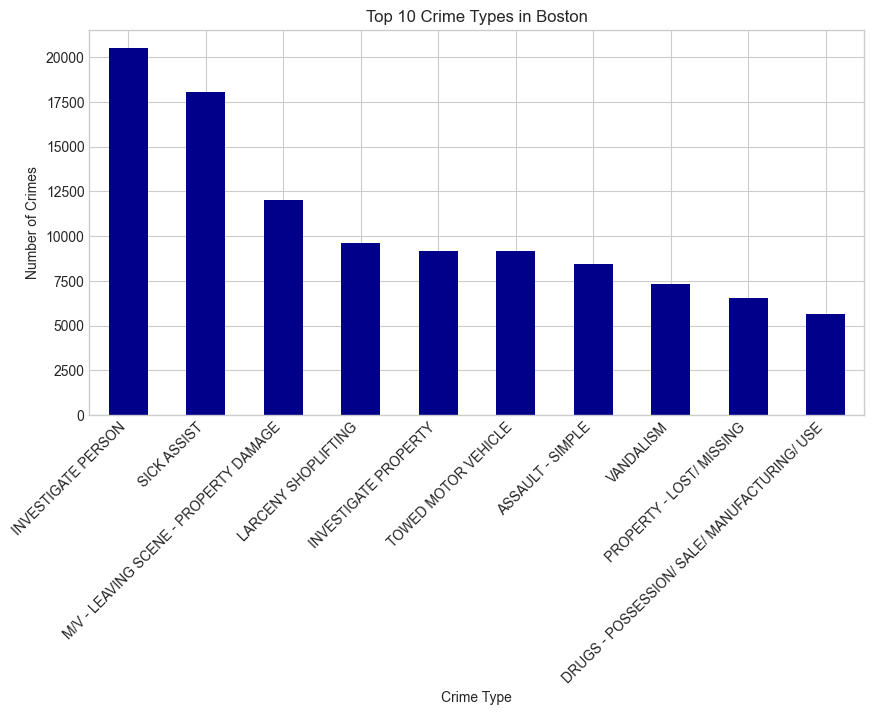

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

print("Boston Cleaned Shape:", boston_clean.shape)
print("Columns:", boston_clean.columns.tolist())

# ========= 1. BASIC STATS =========

print("\n=== Missing Values ===")
print(boston_clean.isnull().sum())

print("\n=== Summary Statistics ===")
display(boston_clean.describe(include='all'))

print("\nUnique Crime Types:", boston_clean['Crime_Type'].nunique())

# ========= 2. CRIME TYPE DISTRIBUTION =========

plt.figure(figsize=(10,5))
boston_clean['Crime_Type'].value_counts().head(10).plot(kind='bar', color='darkblue')
plt.title('Top 10 Crime Types in Boston')
plt.ylabel('Number of Crimes')
plt.xlabel('Crime Type')
plt.xticks(rotation=45, ha='right')
plt.show()


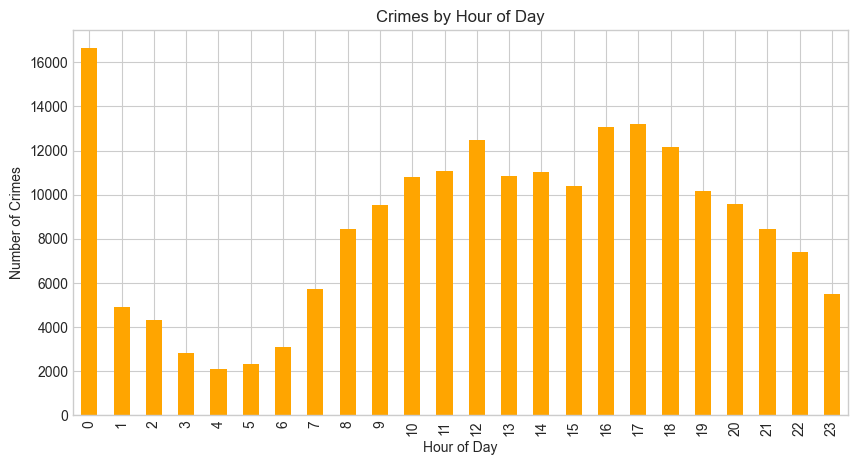

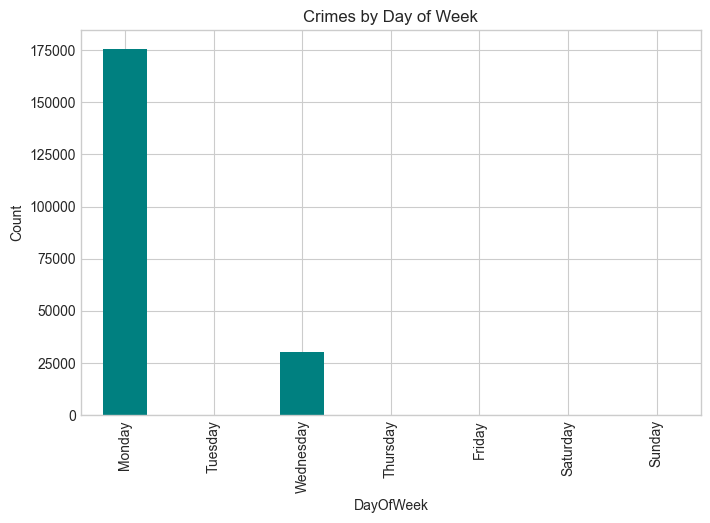

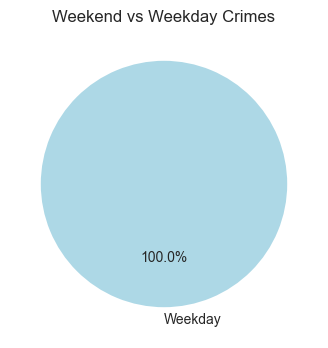

In [3]:
# Crimes by Hour
plt.figure(figsize=(10,5))
boston_clean['Hour'].value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Crimes by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Crimes')
plt.show()

# Crimes by Day of Week
plt.figure(figsize=(8,5))
day_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
boston_clean['DayOfWeek'].map(day_map).value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).plot(kind='bar', color='teal')
plt.title('Crimes by Day of Week')
plt.ylabel('Count')
plt.show()

# Weekend vs Weekday
plt.figure(figsize=(5,4))
boston_clean['IsWeekend'].value_counts().plot(kind='pie',
                                              labels=['Weekday','Weekend'],
                                              autopct='%1.1f%%', startangle=90,
                                              colors=['lightblue','salmon'])
plt.title('Weekend vs Weekday Crimes')
plt.ylabel('')
plt.show()


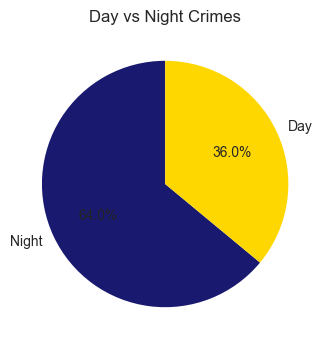

In [4]:
plt.figure(figsize=(5,4))
boston_clean['Light_Condition'].value_counts().plot(kind='pie', 
                                                    labels=['Night','Day'], 
                                                    autopct='%1.1f%%', 
                                                    startangle=90, 
                                                    colors=['midnightblue','gold'])
plt.title('Day vs Night Crimes')
plt.ylabel('')
plt.show()


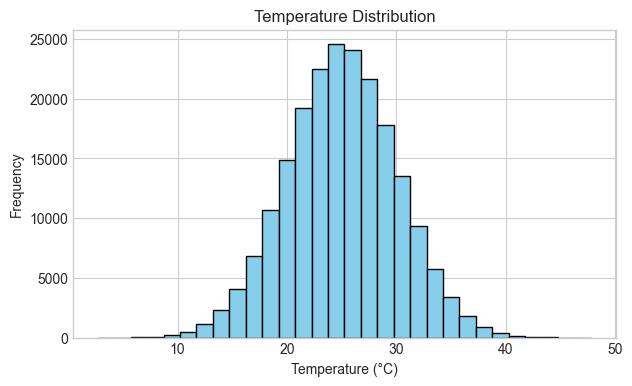

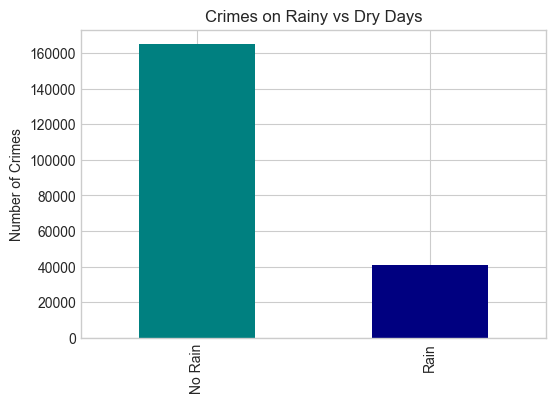

/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_5547/1689909954.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Light_Condition', y='Temperature', data=boston_clean, palette='coolwarm')


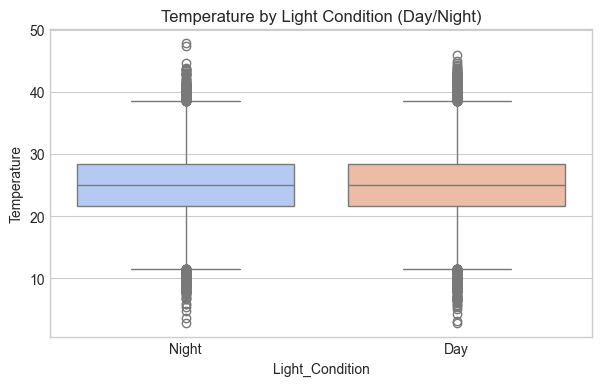

In [5]:
# Temperature Distribution
plt.figure(figsize=(7,4))
plt.hist(boston_clean['Temperature'], bins=30, color='skyblue', edgecolor='black')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

# Rain vs Crime
plt.figure(figsize=(6,4))
rain_counts = boston_clean.groupby('Rain')['Crime_Type'].count()
rain_counts.index = ['No Rain','Rain']
rain_counts.plot(kind='bar', color=['teal','navy'])
plt.title('Crimes on Rainy vs Dry Days')
plt.ylabel('Number of Crimes')
plt.show()

# Temperature vs Light Condition
plt.figure(figsize=(7,4))
sns.boxplot(x='Light_Condition', y='Temperature', data=boston_clean, palette='coolwarm')
plt.title('Temperature by Light Condition (Day/Night)')
plt.xticks([0,1], ['Night','Day'])
plt.show()


/var/folders/40/xpskrwgs1l1734zl9j0227hw0000gn/T/ipykernel_5547/3310695908.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Zone', data=boston_clean, palette='viridis')


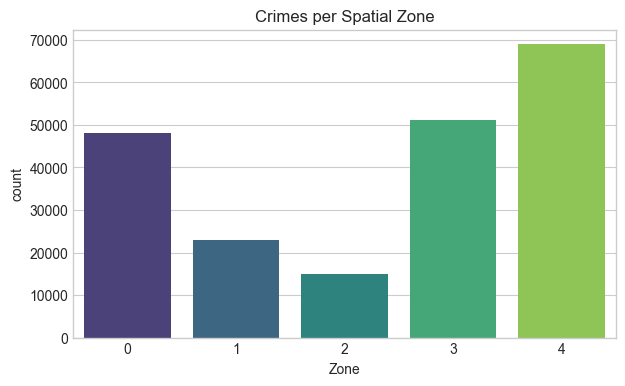

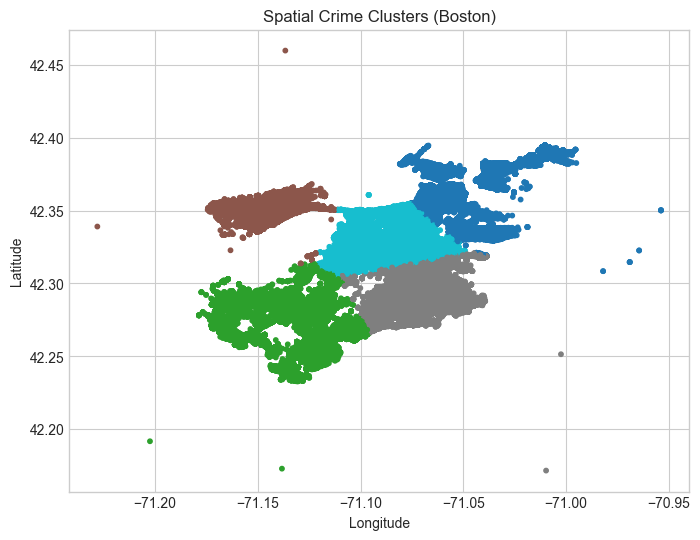

In [6]:
# Crimes per Zone
plt.figure(figsize=(7,4))
sns.countplot(x='Zone', data=boston_clean, palette='viridis')
plt.title('Crimes per Spatial Zone')
plt.show()

# Optional: Scatter Map of Zones
plt.figure(figsize=(8,6))
plt.scatter(boston_clean['Longitude'], boston_clean['Latitude'], c=boston_clean['Zone'], cmap='tab10', s=10)
plt.title('Spatial Crime Clusters (Boston)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


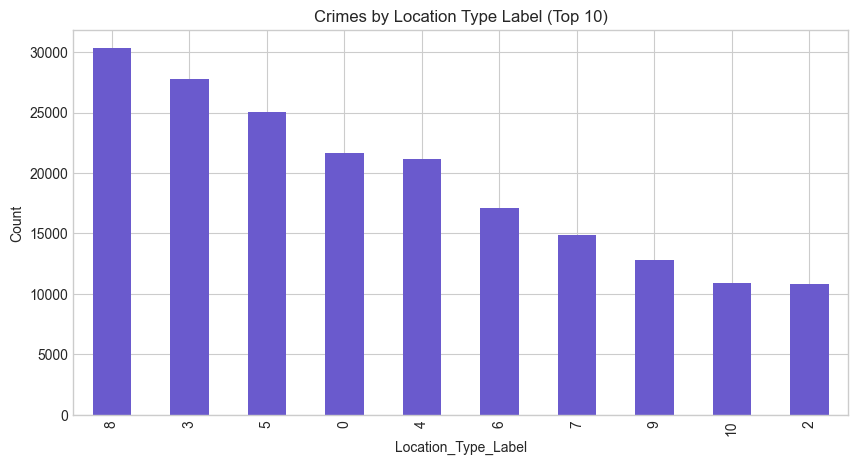

In [7]:
# Crimes by Location Type Label (Top 10)
plt.figure(figsize=(10,5))
boston_clean['Location_Type_Label'].value_counts().head(10).plot(kind='bar', color='slateblue')
plt.title('Crimes by Location Type Label (Top 10)')
plt.xlabel('Location_Type_Label')
plt.ylabel('Count')
plt.show()


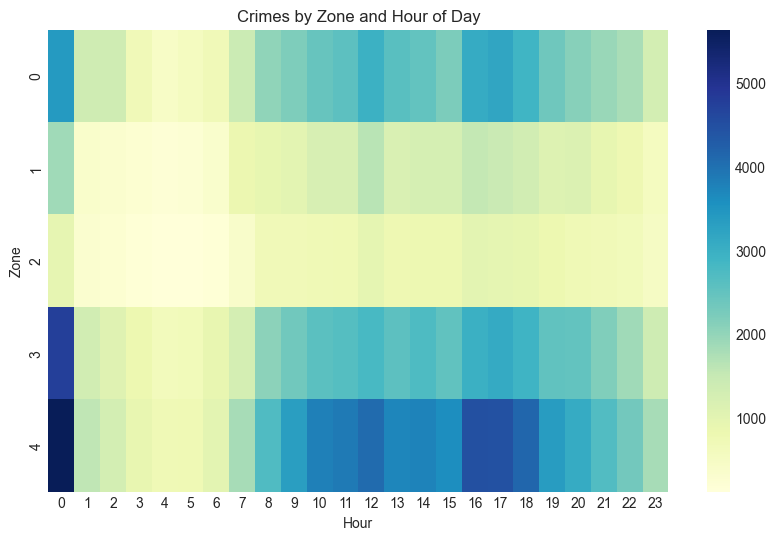

In [8]:
# Zone vs Hour heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pd.crosstab(boston_clean['Zone'], boston_clean['Hour']), cmap='YlGnBu')
plt.title('Crimes by Zone and Hour of Day')
plt.show()
